In [1]:
import pandas as pd

import statsmodels.graphics.tsaplots as tg 
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

upload data

In [2]:
df = pd.read_csv('../field8_4Year_time_series.csv')
df = df.rename(columns={"Unnamed: 0": "date"})
ts = df['gdd']
len(ts)

1096

## Correlation analisys in time series data

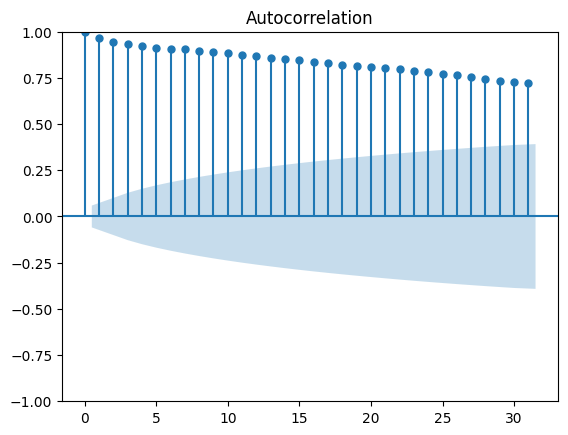

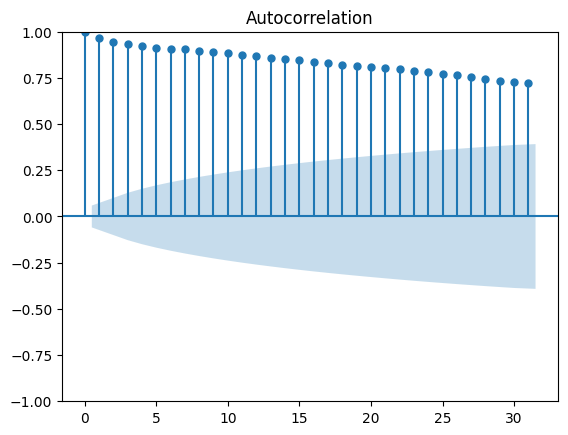

In [3]:
tg.plot_acf(ts)

autocorrelated data

## Sesonality

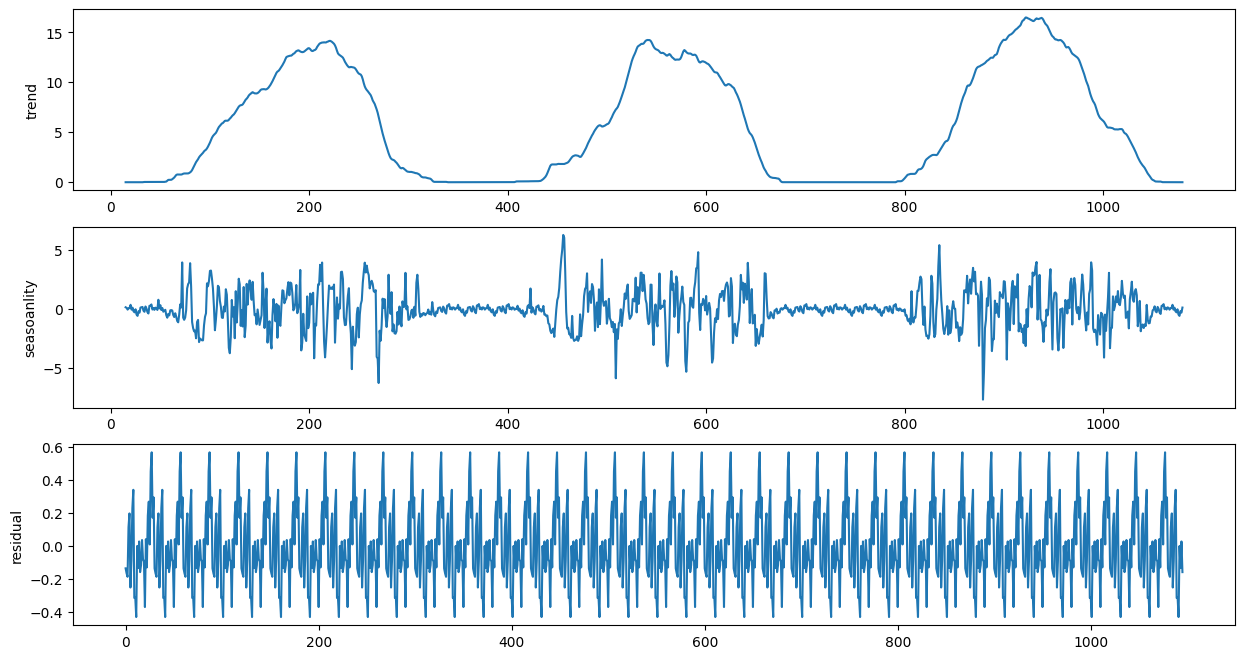

In [4]:

res = seasonal_decompose(ts, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

some seasonality in the data

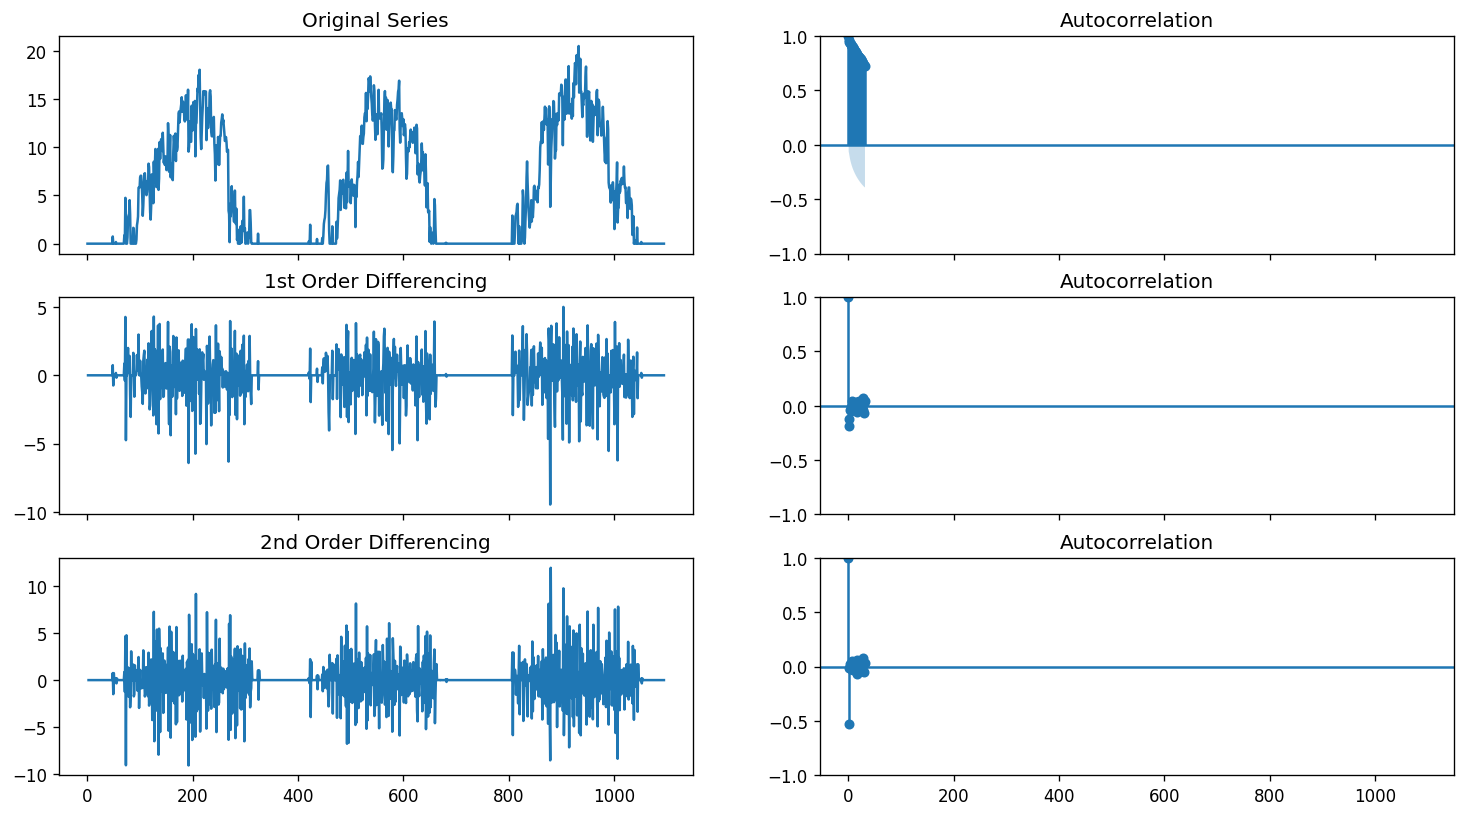

ADF Statistic for 1st Order Differencing
ADF Statistic: -18.472843
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -13.797978
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [5]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')
tg.plot_acf(ts, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')
tg.plot_acf(ts.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(ts.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
tg.plot_acf(ts.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(ts.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(ts.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

time series reachees stationarity after two orders of differencing

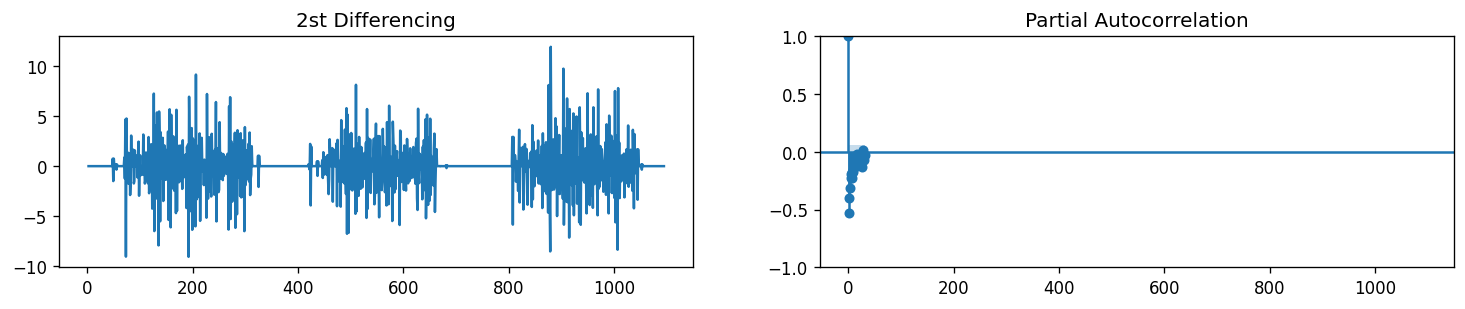

In [6]:
# PACF plot of 2st differenced series
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ts.diff().diff()); axes[0].set_title('2st Differencing')
axes[1].set(ylim=(0,5))
tg.plot_pacf(ts.diff().diff().dropna(), ax=axes[1])

plt.show()

PACF returns sigificance at Lag 1, meaning use p=1 for ARIMA model.

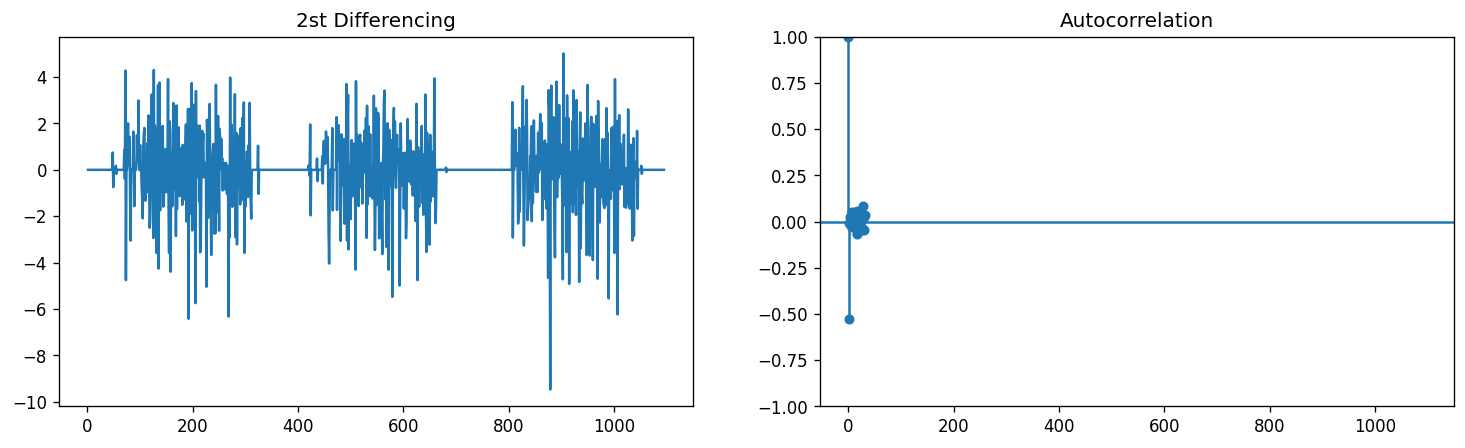

In [7]:
# ACF plot of 2st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ts.diff()); axes[0].set_title('2st Differencing')
axes[1].set(ylim=(0,1))
tg.plot_acf(ts.diff().diff().dropna(), ax=axes[1])

plt.show()

 ACF is  comarable with PCF, so use q=1

## Data preprocessing

In [8]:
ts_train = ts.loc[0:950]
ts_test = ts.loc[951:len(ts)]

## Building the ARIMA model

In [9]:
model = ARIMA(ts_train, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdd   No. Observations:                  951
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1695.074
Date:                Sat, 11 Nov 2023   AIC                           3398.147
Time:                        12:55:58   BIC                           3417.577
Sample:                             0   HQIC                          3405.550
                                - 951                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6672      2.525      2.245      0.025       0.719      10.616
ar.L1          0.9840      0.007    133.849      0.000       0.970       0.998
ma.L1         -0.2620      0.026    -10.255      0.0

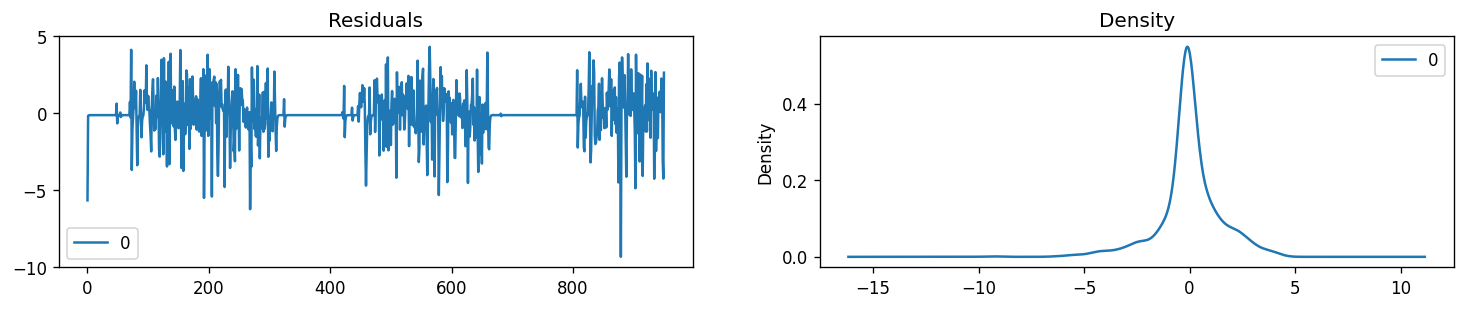

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors should be a Gaussian with a zero mean and uniform variance. With this can now proceed with fitting our initial time series with our model.

C:\Users\thoma\AppData\Local\Temp\ipykernel_14252\3502520460.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


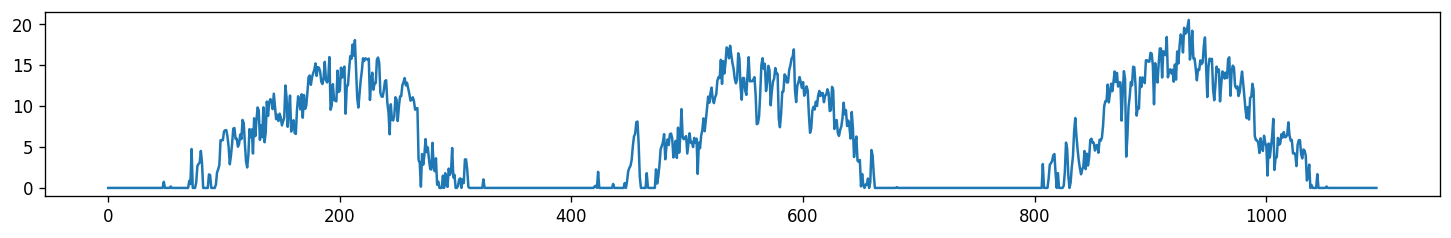

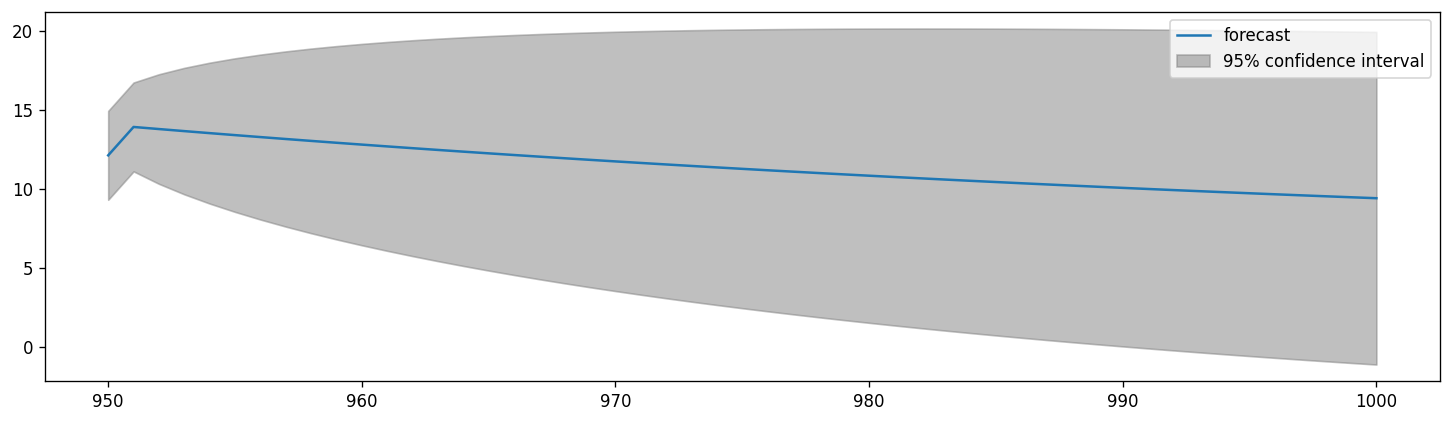

In [11]:
fig, ax = plt.subplots(figsize=(15,2))
ax = ts.plot(ax=ax)
fig = plot_predict(model_fit,start=950,end=1000, dynamic=False)
fig.show()

In [12]:
model_fit.save('gdd_forecast_arima', remove_data=False)

In [26]:
ts_test_predict=model_fit.predict(start=952,end=len(ts))

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(ts_test, ts_test_predict)) 

5.0573801461469206

Image

In [28]:
df_predict = df.loc[len(ts)-5:len(ts)]
df_predict['prediction'] = model_fit.predict(start=len(ts)-5,end=len(ts))


C:\Users\thoma\AppData\Local\Temp\ipykernel_14252\57691807.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
ci_forcast=model_fit.get_forecast(steps=5)
df_predict['90%_CI_low']=pd.DataFrame(ci_forcast.summary_frame(alpha=0.10)).loc[:,'mean_ci_lower']
df_predict['90%_CI_upper']=pd.DataFrame(ci_forcast.summary_frame(alpha=0.10)).loc[:,'mean_ci_upper']

C:\Users\thoma\AppData\Local\Temp\ipykernel_14252\2238114429.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\thoma\AppData\Local\Temp\ipykernel_14252\2238114429.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = go.Figure([
        go.Scatter(
            name='GDD Prediction',
            x=df_predict['date'],
            y=df_predict['prediction'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
        ),
        go.Scatter(
            name='90%_CI_upper',
            x=df_predict['date'],
            y=df_predict['prediction'] + df_predict['90%_CI_upper'],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='90%_CI_low',
            x=df_predict['date'],
            y=df_predict['prediction'] - df_predict['90%_CI_low'],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])
fig.show()

In [33]:
df_predict

,date,gdd,pmm,tmax,tmean,tmin,elevation,exposure,slope,ndvi,ndwi,reci,prediction,90%_CI_low,90%_CI_upper
1091,2022-12-27,0.0,0.000000,11.412840,4.662087,2.388653,234.68951,117.24225,13.417278,0.108773,0.008856,0.246507,6.524009,NaN,NaN
1092,2022-12-28,0.0,0.000000,5.971036,2.133928,0.444098,234.68951,117.24225,13.417278,NaN,NaN,NaN,6.510260,NaN,NaN
1093,2022-12-29,0.0,0.000000,6.090785,2.023190,0.641258,234.68951,117.24225,13.417278,NaN,NaN,NaN,6.496732,NaN,NaN
1094,2022-12-30,0.0,0.059191,6.178758,3.927300,2.044797,234.68951,117.24225,13.417278,NaN,NaN,NaN,6.483421,NaN,NaN
1095,2022-12-31,0.0,0.000000,10.603518,6.389738,3.237297,234.68951,117.24225,13.417278,-0.001460,0.064247,-0.000848,6.470324,NaN,NaN
